In [ ]:
# @title Running in Colab

from IPython.display import HTML, Javascript, display

display(
    HTML(
        """<a href="https://colab.research.google.com/github/evan-lloyd/mechinterp-experiments/blob/main/tiny_stories_sae/e2e_demo.ipynb" target="_blank" id="colab-button">
            <button style="background-color: #4285f4; color: white; padding: 10px 20px; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">
                Run this notebook in Google Colab
            </button>
        </a>"""
    )
)
display(
    Javascript("""
        setTimeout(() => {
            if(typeof google.colab != "undefined") {
                document.querySelector("#colab-button").remove()
            }
        }, 0);
        """)
)

<IPython.core.display.Javascript object>

# Initialize notebook environment


In [ ]:
import os

# If we're running in Colab, we need to clone the non-notebook source from git.
if os.getenv("COLAB_RELEASE_TAG") and not os.path.isdir(
    "/content/mechinterp-experiments"
):
    ip = get_ipython()  #  pyright: ignore[reportUndefinedVariable]
    ip.run_cell_magic(
        "bash",
        "",
        """
    git clone --filter=blob:none --no-checkout https://github.com/evan-lloyd/mechinterp-experiments.git
    cd mechinterp-experiments
    git sparse-checkout init --no-cone
    echo "/tiny_stories_sae" > .git/info/sparse-checkout
    git checkout
  """,
    )
    ip.run_line_magic("cd", "mechinterp-experiments/tiny_stories_sae")
else:
    print("Already cloned source, or not running in Colab.")

# Nice for dev, but not needed for Colab.
try:
    # This uses a library called jurigged to hot-reload code when it is changed.
    # For reasons I've never been able to figure out, the IPython %autoreload magic
    # completely fails to work with the kind of structure I use in this notebook.
    import tiny_stories_sae._autoreload
except Exception:
    raise

Already cloned source, or not running in Colab.


In [3]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

# Tweak TRAINING_BATCH_SIZE for your hardware if necessary
if torch.cuda.is_available():
    TRAINING_DEVICE = "cuda"
    TRAINING_BATCH_SIZE = 64
    E2E_BATCH_SIZE = 8
elif torch.mps.is_available():
    TRAINING_DEVICE = "mps"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2
else:
    TRAINING_DEVICE = "cpu"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
training_dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
validation_dataset = load_dataset(
    "roneneldan/TinyStories", split="validation", streaming=True
)
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M").to(
    TRAINING_DEVICE
)

print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [4]:
# Caches model activations to these directories; modify if necessary, or set to None to disable.
# These take up ~16GB and ~1.5GB respectively, but will save a fair bit of time when running
# the notebook, since they can be re-used across all methods we're comparing.
TRAINING_CACHE_DIR = ".training_cache"
VALIDATION_CACHE_DIR = ".validation_cache"
NUM_TRAINING_TOKENS = int(1e6)
EVAL_INTERVAL = int(1e5)
NUM_VALIDATION_TOKENS = int(1e5)
D_MODEL = model.config.hidden_size
D_SAE = D_MODEL * 4
TOKENIZER_BATCH_SIZE = 128

# Train SAEs for comparison


In [ ]:
from tiny_stories_sae.sae import SAE
from tiny_stories_sae.training import TrainingConfig, TrainingMethod, train

saes = {
    method: {
        layer: SAE(
            D_MODEL,
            D_SAE,
            device=model.device,
            kind="topk",
            topk=100,
        )
        for layer in range(model.config.num_layers)
    }
    for method in TrainingMethod
}

training_config = {
    method: TrainingConfig(
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        training_batch_size=TRAINING_BATCH_SIZE,
        e2e_batch_size=E2E_BATCH_SIZE,
        num_train_tokens=NUM_TRAINING_TOKENS,
        dense_weight=0.0,
        idempotency_weight=0.0,
        eval_interval=int(1e4),
        train_layers=list(range(model.config.num_layers)),
        lr=1e-3,
        use_next_layer_sae=method is TrainingMethod.next_layer,
        next_reconstruction_weight=1.0 if method is TrainingMethod.next_layer else 0.0,
        reconstruction_weight=1.0,
        use_kl_on_final_layer=True,
        balance_reconstruction_losses=method is TrainingMethod.next_layer,
        use_weighted_mask=False,
        method=method,
        finetune_fraction=0.10 if method is TrainingMethod.finetuned else None,
    )
    for method in TrainingMethod
}

training_results = {}

In [ ]:
import os

from tiny_stories_sae.training import build_cache

if TRAINING_CACHE_DIR and (
    not os.path.exists(TRAINING_CACHE_DIR) or not os.listdir(TRAINING_CACHE_DIR)
):
    build_cache(
        TRAINING_CACHE_DIR,
        model,
        tokenizer,
        training_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_TRAINING_TOKENS,
    )

if VALIDATION_CACHE_DIR and (
    not os.path.exists(VALIDATION_CACHE_DIR) or not os.listdir(VALIDATION_CACHE_DIR)
):
    build_cache(
        VALIDATION_CACHE_DIR,
        model,
        tokenizer,
        validation_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_VALIDATION_TOKENS,
    )

## Next-layer auxiliary loss (my method)


In [9]:
training_results[TrainingMethod.next_layer] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer],
    training_dataset,
    training_config[TrainingMethod.next_layer],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## Full end-to-end training

Recreation of the method SAE_e2e+ds from

> Braun, Dan, Jordan Taylor, Nicholas Goldowsky-Dill, and Lee Sharkey. 2024. “Identifying Functionally Important Features with End-to-End Sparse Dictionary Learning.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2405.12241.


In [10]:
training_results[TrainingMethod.e2e] = train(
    model,
    tokenizer,
    saes[TrainingMethod.e2e],
    training_dataset,
    training_config[TrainingMethod.e2e],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

Layer 2

Layer 1

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## End-to-end fine-tuning

Recreation of the KL fine-tuning method from

> Karvonen, Adam. 2025. “Revisiting End-to-End Sparse Autoencoder Training: A Short Finetune Is All You Need.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2503.17272.


In [11]:
training_results[TrainingMethod.finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.finetuned],
    training_dataset,
    training_config[TrainingMethod.finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 3

Layer 2

Layer 1

Layer 0

  0%|          | 0/97873 [00:00<?, ?it/s]

# Evaluations and comparisons


## Train-time evaluations

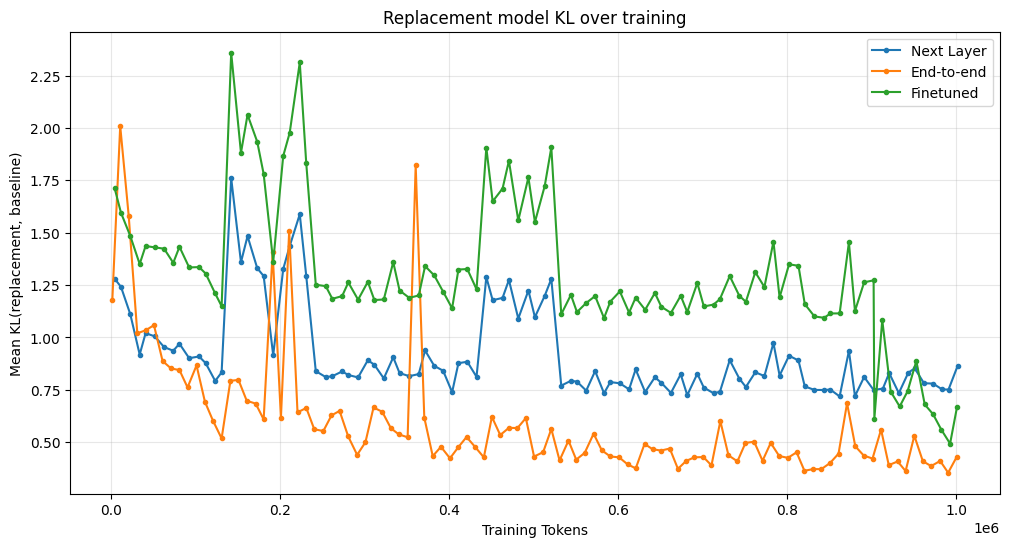

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for method in training_results:
    data = training_results[method][0]['rep_kl']
    tokens, kl_values = zip(*data)
    plt.plot(tokens, kl_values, label=method.value, marker='o', markersize=3)

plt.xlabel('Training Tokens')
plt.ylabel('Mean KL(replacement, baseline)')
plt.title('Replacement model KL over training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


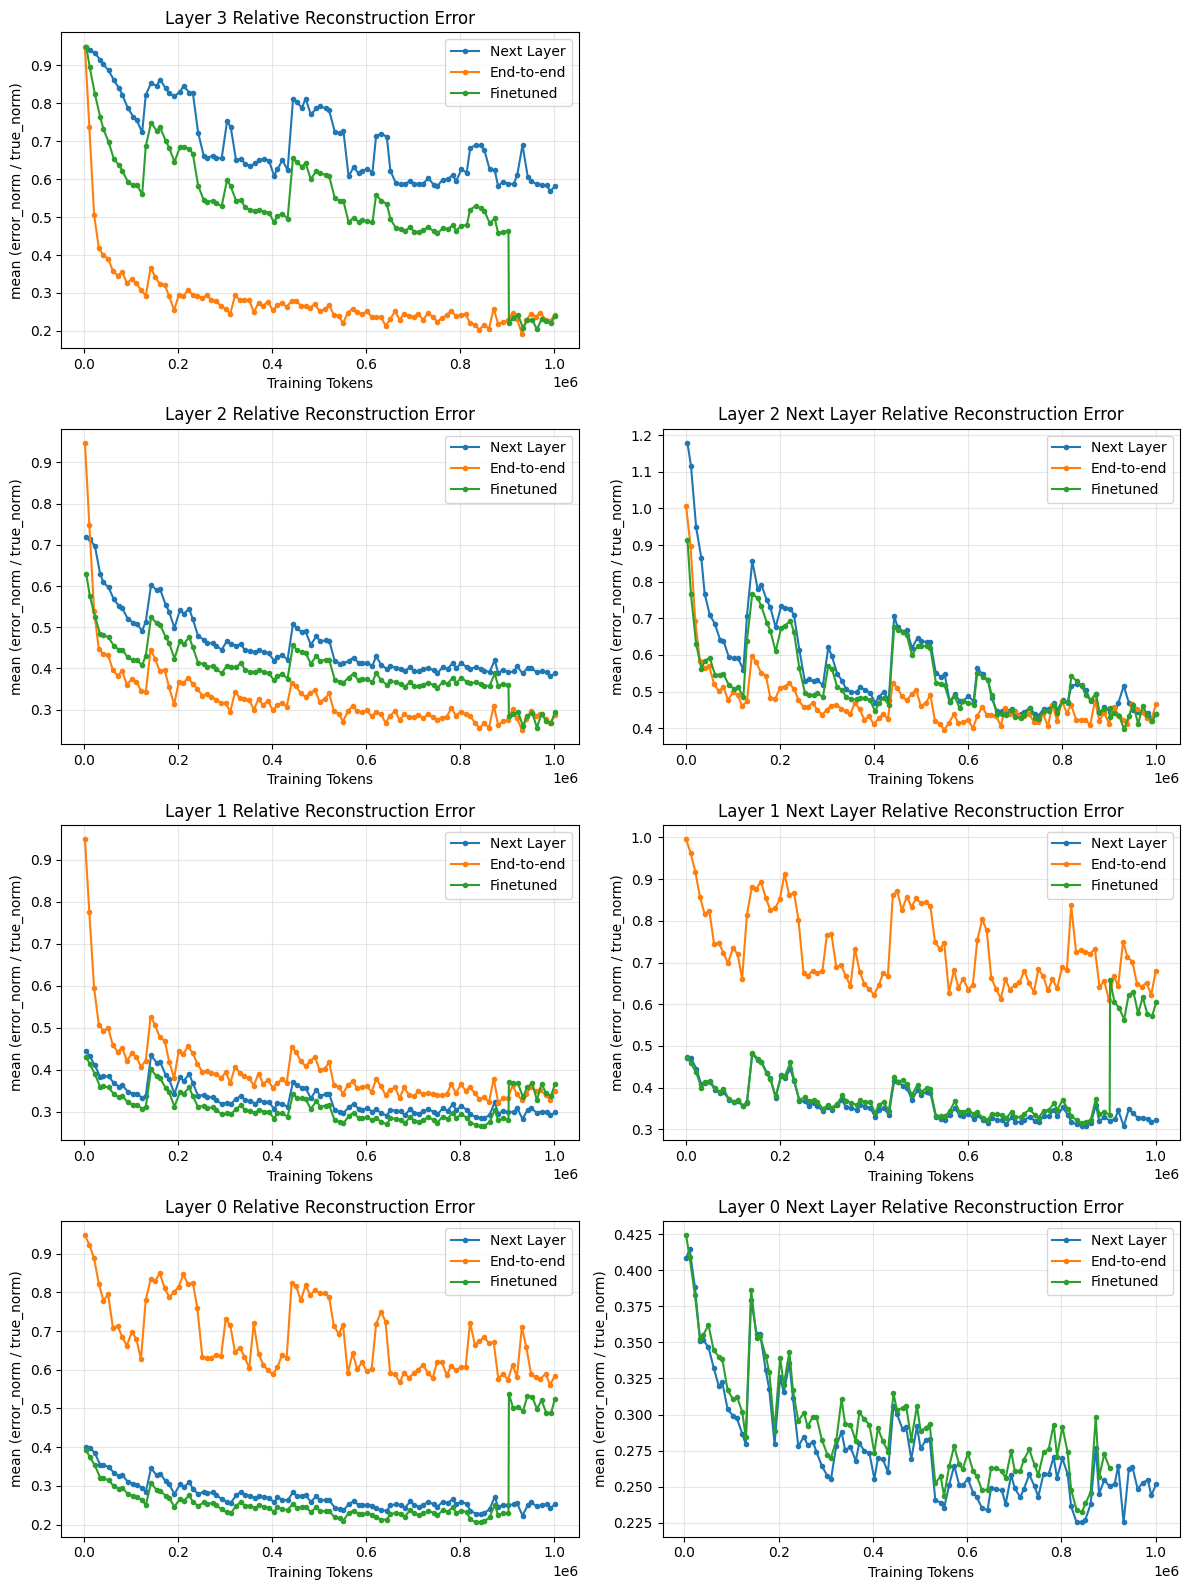

In [23]:
fig, axes = plt.subplots(model.config.num_layers, 2, figsize=(12, 4 * model.config.num_layers))

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    # Plot rcn (relative reconstruction norm)
    ax1 = axes[i, 0]
    for method in training_results:
        data = training_results[method][layer]['rcn']
        tokens, rcn_values = zip(*data)
        ax1.plot(tokens, rcn_values, label=method.value, marker='o', markersize=3)

    ax1.set_xlabel('Training Tokens')
    ax1.set_ylabel('mean (error_norm / true_norm)')
    ax1.set_title(f'Layer {layer} Relative Reconstruction Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot next_rcn (next layer relative reconstruction norm)
    if layer < model.config.num_layers - 1:
        ax2 = axes[i, 1]
        for method in training_results:
            data = training_results[method][layer]['next_rcn']
            tokens, next_rcn_values = zip(*data)
            ax2.plot(tokens, next_rcn_values, label=method.value, marker='o', markersize=3)

        ax2.set_xlabel('Training Tokens')
        ax2.set_ylabel('mean (error_norm / true_norm)')
        ax2.set_title(f'Layer {layer} Next Layer Relative Reconstruction Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        axes[i, 1].set_visible(False)

plt.tight_layout()
plt.show()


## Validation set evals

In [ ]:
from tiny_stories_sae.validation import validate_saes

validation_evals = {}
replacement_evals = {}
position_ids = {}
for method in TrainingMethod:
    validation_evals[method], replacement_evals[method], position_ids[method] = (
        validate_saes(
            model,
            tokenizer,
            saes[method],
            validation_dataset,
            num_tokens=NUM_VALIDATION_TOKENS,
            tokenizer_batch_size=training_config[method].tokenizer_batch_size,
            inference_batch_size=training_config[method].training_batch_size,
            cache_dir=VALIDATION_CACHE_DIR,
        )
    )

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

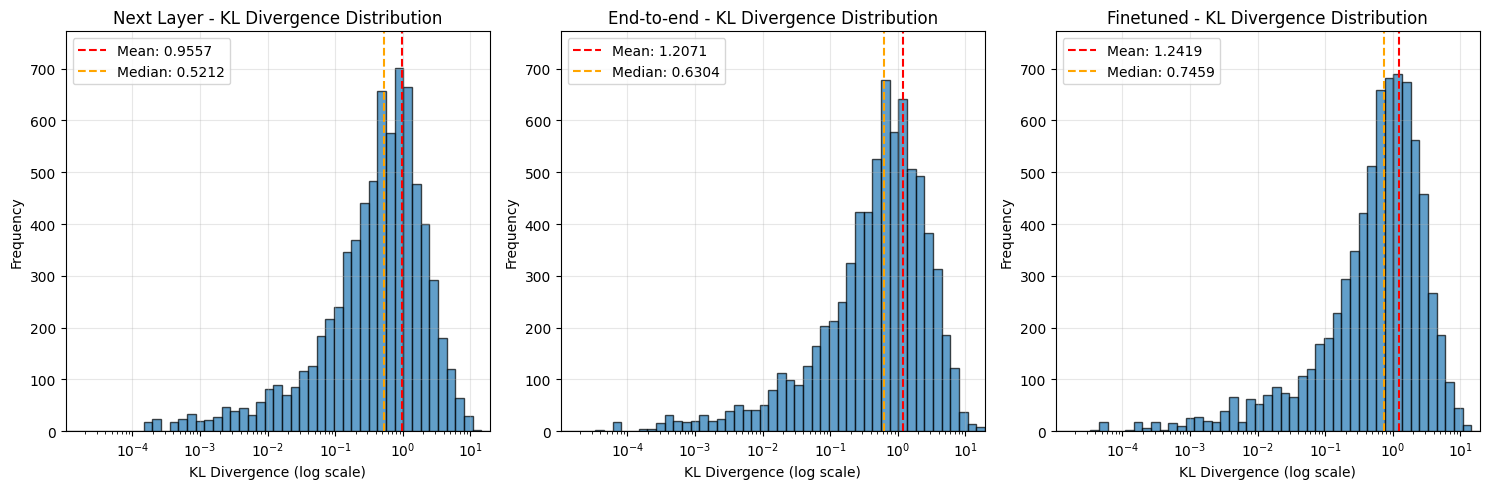

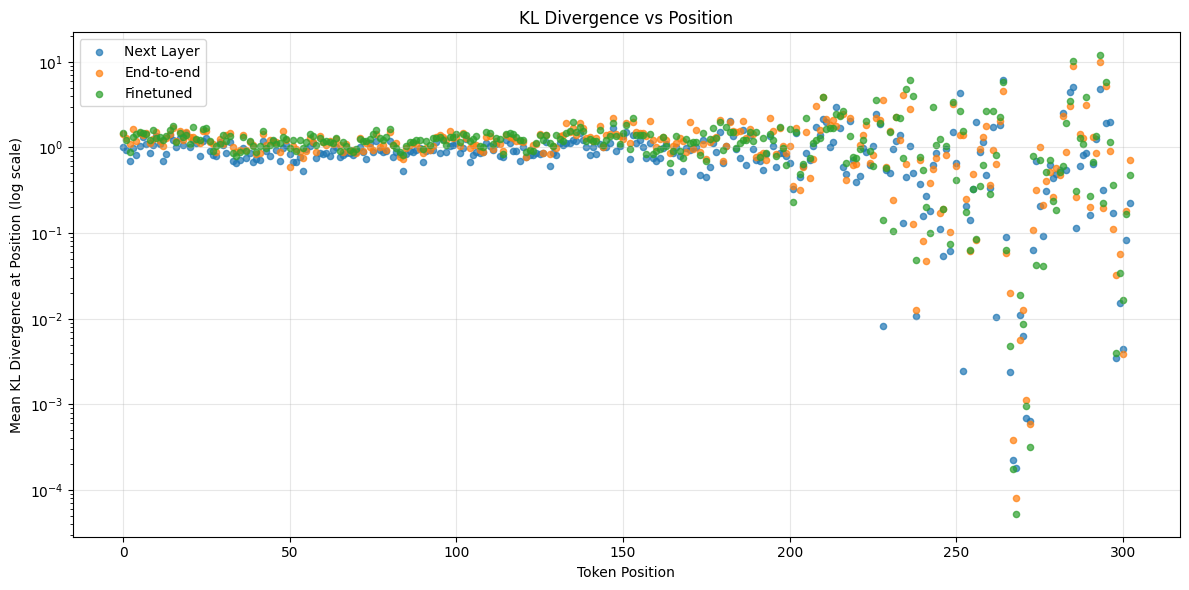

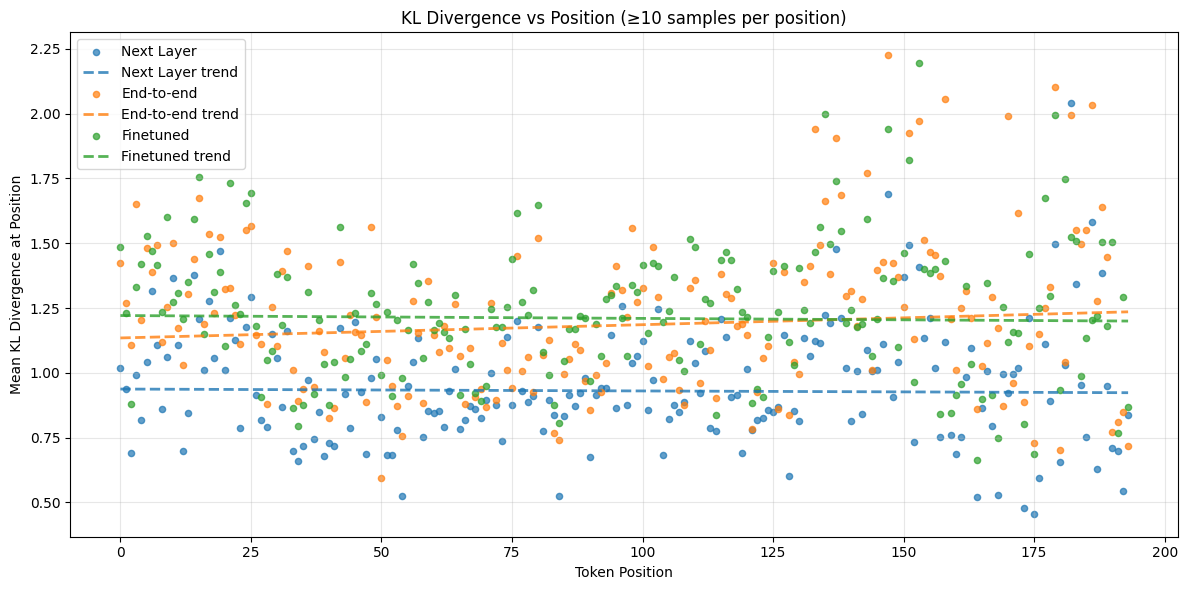

In [15]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

# Plot histograms of KL divergence for each method
fig, axes = plt.subplots(1, len(TrainingMethod), figsize=(15, 5))
if len(TrainingMethod) == 1:
    axes = [axes]

# Calculate global min/max for consistent bins across all methods
all_kl_values = []
for method in TrainingMethod:
    kl_values = replacement_evals[method]["kl"]
    all_kl_values.extend(kl_values[kl_values > 0])

global_min = np.min(all_kl_values)
global_max = np.max(all_kl_values)
log_bins = np.logspace(np.log10(global_min), np.log10(global_max), 50)

# Calculate global y-axis limits
max_frequency = 0
for method in TrainingMethod:
    kl_values = replacement_evals[method]["kl"]
    counts, _ = np.histogram(kl_values, bins=log_bins)
    max_frequency = max(max_frequency, np.max(counts))

for i, method in enumerate(TrainingMethod):
    ax = axes[i]
    kl_values = replacement_evals[method]["kl"]

    # Create histogram with consistent bins
    ax.hist(kl_values, bins=log_bins, alpha=0.7, edgecolor="black")
    ax.set_xscale("log")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(0, max_frequency * 1.1)
    ax.set_xlabel("KL Divergence (log scale)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{method.value} - KL Divergence Distribution")
    ax.grid(True, alpha=0.3)

    # Add statistics as text
    mean_kl = np.mean(kl_values)
    median_kl = np.median(kl_values)
    ax.axvline(mean_kl, color="red", linestyle="--", label=f"Mean: {mean_kl:.4f}")
    ax.axvline(
        median_kl, color="orange", linestyle="--", label=f"Median: {median_kl:.4f}"
    )
    ax.legend()

plt.tight_layout()
plt.show()

# Plot KL divergence vs position_id for each method on the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for method in TrainingMethod:
    kl_values = replacement_evals[method]["kl"]
    pos_ids = position_ids[method]

    # Group KL values by position_id and compute means
    pos_kl_dict = defaultdict(list)
    for kl, pos in zip(kl_values, pos_ids):
        pos_kl_dict[pos].append(kl)

    # Compute mean KL for each position
    positions = []
    mean_kls = []
    for pos in sorted(pos_kl_dict.keys()):
        positions.append(pos)
        mean_kls.append(np.mean(pos_kl_dict[pos]))

    # Create scatter plot for this method
    ax.scatter(positions, mean_kls, alpha=0.7, s=20, label=method.value)

ax.set_yscale("log")

ax.set_xlabel("Token Position")
ax.set_ylabel("Mean KL Divergence at Position (log scale)")
ax.set_title("KL Divergence vs Position")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Plot KL divergence vs position_id for each method on the same plot (filtered)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for method in TrainingMethod:
    kl_values = replacement_evals[method]["kl"]
    pos_ids = position_ids[method]

    # Group KL values by position_id and compute means
    pos_kl_dict = defaultdict(list)
    for kl, pos in zip(kl_values, pos_ids):
        pos_kl_dict[pos].append(kl)

    # Compute mean KL for each position, filtering out positions with < 10 samples
    positions = []
    mean_kls = []
    for pos in sorted(pos_kl_dict.keys()):
        if len(pos_kl_dict[pos]) >= 10:  # Filter out positions with fewer than 10 samples
            positions.append(pos)
            mean_kls.append(np.mean(pos_kl_dict[pos]))

    # Create scatter plot for this method
    ax.scatter(positions, mean_kls, alpha=0.7, s=20, label=method.value)
    
    # Add linear regression line
    # Convert to numpy arrays for regression
    x = np.array(positions)
    y = np.log(mean_kls)  # Use log of KL values since we're on log scale
    
    # Perform linear regression
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    
    # Generate regression line
    x_line = np.linspace(min(positions), max(positions), 100)
    y_line = np.exp(poly(x_line))  # Convert back from log space
    
    ax.plot(x_line, y_line, '--', alpha=0.8, linewidth=2, 
            label=f'{method.value} trend')

ax.set_xlabel("Token Position")
ax.set_ylabel("Mean KL Divergence at Position")
ax.set_title("KL Divergence vs Position (≥10 samples per position)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tiny_stories_sae.validation import generate_with_replacement

# Generate completions with and without SAE replacement
prompt = "Once upon a time"
results = {}

# Generate without replacement (baseline)
print("Generating baseline completion...")
baseline_tokens = generate_with_replacement(
    model, tokenizer, prompt, saes={}, do_sample=False, stream=False
)
baseline_text = tokenizer.decode(baseline_tokens[0], skip_special_tokens=True)
results["Baseline"] = baseline_text

# Generate with each SAE method
for method in TrainingMethod:
    print(f"Generating completion with {method.value}...")
    sae_dict = {layer: saes[method][layer] for layer in range(4)}
    method_tokens = generate_with_replacement(
        model,
        tokenizer,
        prompt,
        saes=sae_dict,
        do_sample=False,
        stream=False,
    )
    method_text = tokenizer.decode(method_tokens[0], skip_special_tokens=True)
    results[method.value] = method_text

# Display results in HTML table
from IPython.display import HTML

html_table = """
<table border="1" style="border-collapse: collapse; width: 100%;">
<tr style="background-color: #f2f2f2;">
<th style="padding: 10px; text-align: left;">Method</th>
<th style="padding: 10px; text-align: left;">Generated Text</th>
</tr>
"""

for method_name, text in results.items():
    html_table += f"""
<tr>
<td style="padding: 10px; vertical-align: top; font-weight: bold;">{method_name}</td>
<td style="padding: 10px; font-family: monospace; white-space: pre-wrap;">{text}</td>
</tr>
"""

html_table += "</table>"

display(HTML(html_table))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating baseline completion...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with End-to-end...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Finetuned...


Method,Generated Text
Baseline,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, red apple on the ground. She picked it up and took a bite. It was so juicy and delicious! Suddenly, she heard a loud noise. It was a big, scary dog! Lily was scared and didn't know what to do. But then, she remembered the apple she had picked earlier. She took a bite and it was even more delicious than before! Lily learned that sometimes things that look scary can be delicious. She also learned that it's important to be brave and not give up. From that day on, Lily always carried an apple with her, just in case she needed to face her fears."
Next Layer,"Once upon a time, there was a little girl named Lily. She loved to play outside and explore the woods. One day, she went on an adventure and found a big, scary animal. The animal was very scary and scared. Lily was scared and wanted to run away. But then, she heard a loud noise. It was the sound of the animal. She ran after the scary animal and tried to catch it, but it was too far. Lily was scared, so she started to cry. The scary animal ran away. When she got home, her mom came and saw what happened. She told her that the scary animal was not nice. She said that the scary animal was not safe. Lily learned that sometimes bad things are wrong and that it's important to be brave. The end."
End-to-end,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sun. One day, she saw a big, red ball in the grass. She picked it up and held it in her hands. ""Wow, this is so big! What is it doing?"" she asked. ""I'm going to play a game,"" said her mom. Lily was so excited. She ran over to the ball and started to roll it around. She laughed and laughed as she rolled the ball faster. Suddenly, the ball started to move. Lily was so excited that she started to roll the ball faster and faster. She was having so much fun! But then, she stopped rolling the red ball again. She rolled the red ball faster and faster until the red ball was gone. Lily was so happy. She had so much fun playing with her red ball."
Finetuned,"Once upon a time, there was a boy named Timmy. He was very happy and loved to play outside. One day, Timmy saw a big, green tree in the park. He ran over to the tree and started to play. Suddenly, Timmy saw a big, green bird sitting on the tree. The bird looked very hungry. Timmy wanted to help the bird, so he ran over to the tree and said ""Hello, little bird!"" The bird hopped up and said, ""Thank you, Timmy!"" Timmy smiled and said, ""You're very kind!"" The bird smiled and said, ""Yes, I love to play with you. Can I play with you?"" Timmy smiled and said, ""Yes, let's play together!"" They ran around the park, chasing each other and having so much fun. They ran around the park, chasing each other and even ate apples. At last, Timmy was exhausted. He was exhausted and had been so happy to have a snack. ""Thanks, bird. I'll never forget you."" it said, giving him a big smile. Timmy smiled and said, ""Yes, it was nice to share something that made me happy."
